In [1]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.config.list_physical_devices(device_type=None)

import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras import models
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import h5py
from keras import callbacks 
from sklearn.model_selection import KFold

In [18]:
# load data -------------------------------------------------

num = 4000 # number of profiles
nchan = 3 # number of channels

# get spatial dimension
fname = "Out1/profile_%05d.hdf5" %(1)
hf = h5py.File(fname, 'r')
spatial = hf.get('x') # HDF5 dataset "x": shape (4096,), type "<f8">
x = np.array(spatial) #change it to np array
x_size = np.size(np.array(spatial)) #4096; Dimension: (4096,)
hf.close()

data = np.empty((num, x_size, nchan+1), dtype=float)
for i in range(0, num):
    fname = "Out1/profile_%05d.hdf5" %(i+1)
    hf = h5py.File(fname, 'r')
    data[i, :, 0] = np.array(hf.get("red"))
    data[i, :, 1] = np.array(hf.get("grn"))
    data[i, :, 2] = np.array(hf.get("blu"))
    data[i, :, 3] = np.array(hf.get("tau")) #data.shape: (4000, 4096, 4) 4000 profiles, 4096 pixels, 3 channels 
    hf.close()

np.random.seed(4); #same set of numbers will appear every time
np.random.shuffle(data) #number will be in the same order in data

# allocate for training and testing -------------------------
trp = 0.8; # 80 percent to train, includes validation
train_size=int(trp*num)
test_size = num - train_size #20% for testing:0.2*4000=800

# spatial slicing dimensions
os = 8 # output slice size
halo = 2 # edge cells
ts = os + halo * 2 # total input slice size including halos 12
ks = int(ts / 2) # kernel size is half of total size 6
l2r = 511 # number of slices in one profile 

In [4]:
# spatial slicing the profiles

image=np.zeros((l2r*num,ts,3)) 
label=np.zeros((l2r*num,os)) 

for i in range(l2r):
#cut each profile into 511 slices. 
#label: tau channel of the center of each slice(reduced domain), they ignore the edge pixel.
    img= data[:, i*os:i*os+ts, 0:nchan] #input: 12 pixels for one slice, 3 channels 
    lb = data[:, i*os+halo:i*os+halo+os, nchan] #8 pixels for label,the tau channel is the label
    image[i*num:i*num+num]=img
    label[i*num:i*num+num,:]=lb 
print('whole dataset features size: ',image.shape,'whole dataset label size: ', label.shape) #511*4000=2044000

whole dataset features size:  (2044000, 12, 3) whole dataset label size:  (2044000, 8)


In [5]:
predictions = np.empty((test_size,8)) 
predictions.shape

(800, 8)

In [8]:
# CNN over domain -------------------------------------------


def evaluate_model(train_image, test_image, train_label, test_label):
    
    ltype = 'mean_squared_error'
    type2=tf.keras.metrics.RootMeanSquaredError()
    bsize = 1024
    eps = 2000
    
    model_m = models.Sequential()

    model_m.add(layers.Conv1D(nchan*100, kernel_size=ks, activation='relu', input_shape=(ts, nchan))) #kernel size 6, 100 filters for each 3 channel

    model_m.add(layers.Conv1D(nchan*80, kernel_size=4, activation='relu')) #kernel size 4, 80 filters for each 3 channel
    model_m.add(layers.Dropout(0.2))

    model_m.add(layers.Conv1D(8, kernel_size=1)) 
    model_m.add(layers.Dropout(0.2))

    model_m.add(layers.Flatten())
    model_m.add(layers.Dense(os, activation="linear"))#output slice size : 8

    model_m.summary()




    model_m.compile(optimizer='adam',loss=ltype,metrics=[ltype,type2])

    #earlystopping to find the optimal number of epochs 
    earlystopping = callbacks.EarlyStopping(monitor ="val_loss",  
                                                mode ="min", patience = 50,  
                                                restore_best_weights = True,
                                               verbose=1) 

    history = model_m.fit(train_image,train_label,batch_size = bsize,epochs = eps,validation_split=0.125,
                              callbacks =[earlystopping])#validation set(10%)/trainset(80%)=0.125

    # test and predict ---------------------------------------------

    print('test result')
    results = model_m.evaluate(test_image, test_label)
    predictions=model_m.predict(test_image)
    mse = results[0]
    rmse=results[2]

    
    return model_m,rmse,mse,history,predictions

In [9]:
n_folds=5

kf = KFold(n_splits=n_folds)
kf.get_n_splits(image)
print(kf)
ratio=int(image.shape[0]/n_folds)

X_train=np.zeros((n_folds,ratio*(n_folds-1),12,3))
y_train=np.zeros((n_folds,ratio*(n_folds-1),8))
X_test=np.zeros((n_folds,ratio,12,3))
y_test=np.zeros((n_folds,ratio,8))

count=0
for train_index, test_index in kf.split(image):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train[count], X_test[count] = image[train_index], image[test_index]
    y_train[count], y_test[count] = label[train_index], label[test_index]
    count+=1

KFold(n_splits=5, random_state=None, shuffle=False)
TRAIN: [ 408800  408801  408802 ... 2043997 2043998 2043999] TEST: [     0      1      2 ... 408797 408798 408799]
TRAIN: [      0       1       2 ... 2043997 2043998 2043999] TEST: [408800 408801 408802 ... 817597 817598 817599]
TRAIN: [      0       1       2 ... 2043997 2043998 2043999] TEST: [ 817600  817601  817602 ... 1226397 1226398 1226399]
TRAIN: [      0       1       2 ... 2043997 2043998 2043999] TEST: [1226400 1226401 1226402 ... 1635197 1635198 1635199]
TRAIN: [      0       1       2 ... 1635197 1635198 1635199] TEST: [1635200 1635201 1635202 ... 2043997 2043998 2043999]


In [10]:
cv_scores = list()
cv_scores2 = list()
model_history = list()

for n in range(n_folds):
        # split data    
    train_image, test_image, train_label, test_label = X_train[n],X_test[n],y_train[n],y_test[n]
        # evaluate model
    model_m,rmse,mse,history,predictions= evaluate_model(train_image, test_image, train_label, test_label)
    print('MSE on test set in fold'+str(n+1)+' : '+str(mse))
    print('RMSE on test set in fold'+str(n+1)+' : '+str(rmse))

    cv_scores.append(mse)
    cv_scores2.append(rmse)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 7, 300)            5700      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 4, 240)            288240    
_________________________________________________________________
dropout (Dropout)            (None, 4, 240)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 4, 8)              1928      
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 8)              0         
_________________________________________________________________
flatten (Flatten)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 8)                 2

Epoch 63/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 13.2052 - mean_squared_error: 13.2052 - root_mean_squared_error: 3.6338 - val_loss: 12.5712 - val_mean_squared_error: 12.5712 - val_root_mean_squared_error: 3.5456
Epoch 64/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 13.1280 - mean_squared_error: 13.1280 - root_mean_squared_error: 3.6232 - val_loss: 12.0107 - val_mean_squared_error: 12.0107 - val_root_mean_squared_error: 3.4657
Epoch 65/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 13.0283 - mean_squared_error: 13.0283 - root_mean_squared_error: 3.6094 - val_loss: 12.2883 - val_mean_squared_error: 12.2883 - val_root_mean_squared_error: 3.5055
Epoch 66/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 13.0678 - mean_squared_error: 13.0678 - root_mean_squared_error: 3.6149 - val_loss: 12.4781 - val_mean_squared_error: 12.4781 - val_root_mean_squared_error: 3.5324
Epoch 67/2000
1398/1398 

1398/1398 [==============================] - 10s 7ms/step - loss: 11.9798 - mean_squared_error: 11.9798 - root_mean_squared_error: 3.4610 - val_loss: 11.1806 - val_mean_squared_error: 11.1806 - val_root_mean_squared_error: 3.3437
Epoch 130/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 11.9311 - mean_squared_error: 11.9311 - root_mean_squared_error: 3.4540 - val_loss: 10.9663 - val_mean_squared_error: 10.9663 - val_root_mean_squared_error: 3.3115
Epoch 131/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 11.7913 - mean_squared_error: 11.7913 - root_mean_squared_error: 3.4337 - val_loss: 11.1640 - val_mean_squared_error: 11.1640 - val_root_mean_squared_error: 3.3413
Epoch 132/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 11.8915 - mean_squared_error: 11.8915 - root_mean_squared_error: 3.4483 - val_loss: 11.0523 - val_mean_squared_error: 11.0523 - val_root_mean_squared_error: 3.3245
Epoch 133/2000
1398/1398 [=========

1398/1398 [==============================] - 10s 7ms/step - loss: 11.3751 - mean_squared_error: 11.3751 - root_mean_squared_error: 3.3726 - val_loss: 10.6437 - val_mean_squared_error: 10.6437 - val_root_mean_squared_error: 3.2625
Epoch 196/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 11.2935 - mean_squared_error: 11.2935 - root_mean_squared_error: 3.3603 - val_loss: 10.9498 - val_mean_squared_error: 10.9498 - val_root_mean_squared_error: 3.3090
Epoch 197/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 11.2596 - mean_squared_error: 11.2596 - root_mean_squared_error: 3.3555 - val_loss: 10.5502 - val_mean_squared_error: 10.5502 - val_root_mean_squared_error: 3.2481
Epoch 198/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 11.0751 - mean_squared_error: 11.0751 - root_mean_squared_error: 3.3277 - val_loss: 10.6504 - val_mean_squared_error: 10.6504 - val_root_mean_squared_error: 3.2635
Epoch 199/2000
1398/1398 [=========

1398/1398 [==============================] - 10s 7ms/step - loss: 10.7985 - mean_squared_error: 10.7985 - root_mean_squared_error: 3.2860 - val_loss: 10.4315 - val_mean_squared_error: 10.4315 - val_root_mean_squared_error: 3.2298
Epoch 262/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 11.0405 - mean_squared_error: 11.0405 - root_mean_squared_error: 3.3227 - val_loss: 10.4170 - val_mean_squared_error: 10.4170 - val_root_mean_squared_error: 3.2275
Epoch 263/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 10.7475 - mean_squared_error: 10.7475 - root_mean_squared_error: 3.2783 - val_loss: 10.8092 - val_mean_squared_error: 10.8092 - val_root_mean_squared_error: 3.2877
Epoch 264/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 10.7762 - mean_squared_error: 10.7762 - root_mean_squared_error: 3.2826 - val_loss: 10.8704 - val_mean_squared_error: 10.8704 - val_root_mean_squared_error: 3.2970
Epoch 265/2000
1398/1398 [=========

1398/1398 [==============================] - 10s 7ms/step - loss: 10.4288 - mean_squared_error: 10.4288 - root_mean_squared_error: 3.2293 - val_loss: 9.8290 - val_mean_squared_error: 9.8290 - val_root_mean_squared_error: 3.1351
Epoch 328/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 10.4871 - mean_squared_error: 10.4871 - root_mean_squared_error: 3.2383 - val_loss: 10.2231 - val_mean_squared_error: 10.2231 - val_root_mean_squared_error: 3.1974
Epoch 329/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 10.5626 - mean_squared_error: 10.5626 - root_mean_squared_error: 3.2499 - val_loss: 10.0293 - val_mean_squared_error: 10.0293 - val_root_mean_squared_error: 3.1669
Epoch 330/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 10.7024 - mean_squared_error: 10.7024 - root_mean_squared_error: 3.2714 - val_loss: 9.9571 - val_mean_squared_error: 9.9571 - val_root_mean_squared_error: 3.1555
Epoch 331/2000
1398/1398 [=============

Epoch 361/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 10.3140 - mean_squared_error: 10.3140 - root_mean_squared_error: 3.2113 - val_loss: 10.1724 - val_mean_squared_error: 10.1724 - val_root_mean_squared_error: 3.1894
Epoch 362/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 10.3988 - mean_squared_error: 10.3988 - root_mean_squared_error: 3.2247 - val_loss: 9.9408 - val_mean_squared_error: 9.9408 - val_root_mean_squared_error: 3.1529
Epoch 363/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 10.4101 - mean_squared_error: 10.4101 - root_mean_squared_error: 3.2264 - val_loss: 9.7929 - val_mean_squared_error: 9.7929 - val_root_mean_squared_error: 3.1294
Epoch 364/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 10.3726 - mean_squared_error: 10.3726 - root_mean_squared_error: 3.2205 - val_loss: 9.8215 - val_mean_squared_error: 9.8215 - val_root_mean_squared_error: 3.1339
Epoch 365/2000
1398/1398 [

Epoch 395/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 10.1685 - mean_squared_error: 10.1685 - root_mean_squared_error: 3.1885 - val_loss: 9.8532 - val_mean_squared_error: 9.8532 - val_root_mean_squared_error: 3.1390
Epoch 396/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 10.4268 - mean_squared_error: 10.4268 - root_mean_squared_error: 3.2290 - val_loss: 9.6588 - val_mean_squared_error: 9.6588 - val_root_mean_squared_error: 3.1079
Epoch 397/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 10.3799 - mean_squared_error: 10.3799 - root_mean_squared_error: 3.2217 - val_loss: 9.9144 - val_mean_squared_error: 9.9144 - val_root_mean_squared_error: 3.1487
Epoch 398/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 10.3611 - mean_squared_error: 10.3611 - root_mean_squared_error: 3.2187 - val_loss: 10.2828 - val_mean_squared_error: 10.2828 - val_root_mean_squared_error: 3.2067
Epoch 399/2000
1398/1398 [

Epoch 429/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 10.2048 - mean_squared_error: 10.2048 - root_mean_squared_error: 3.1944 - val_loss: 9.9426 - val_mean_squared_error: 9.9426 - val_root_mean_squared_error: 3.1532
Epoch 430/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 10.1911 - mean_squared_error: 10.1911 - root_mean_squared_error: 3.1923 - val_loss: 9.9226 - val_mean_squared_error: 9.9226 - val_root_mean_squared_error: 3.1500
Epoch 431/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 10.1810 - mean_squared_error: 10.1810 - root_mean_squared_error: 3.1907 - val_loss: 9.7931 - val_mean_squared_error: 9.7931 - val_root_mean_squared_error: 3.1294
Epoch 432/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 10.3276 - mean_squared_error: 10.3276 - root_mean_squared_error: 3.2136 - val_loss: 9.7394 - val_mean_squared_error: 9.7394 - val_root_mean_squared_error: 3.1208
Epoch 433/2000
1398/1398 [==

Epoch 463/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 10.2100 - mean_squared_error: 10.2100 - root_mean_squared_error: 3.1952 - val_loss: 9.4872 - val_mean_squared_error: 9.4872 - val_root_mean_squared_error: 3.0801
Epoch 464/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 10.1724 - mean_squared_error: 10.1724 - root_mean_squared_error: 3.1894 - val_loss: 9.7317 - val_mean_squared_error: 9.7317 - val_root_mean_squared_error: 3.1196
Epoch 465/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 10.0348 - mean_squared_error: 10.0348 - root_mean_squared_error: 3.1677 - val_loss: 9.7364 - val_mean_squared_error: 9.7364 - val_root_mean_squared_error: 3.1203
Epoch 466/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 10.0992 - mean_squared_error: 10.0992 - root_mean_squared_error: 3.1779 - val_loss: 9.6182 - val_mean_squared_error: 9.6182 - val_root_mean_squared_error: 3.1013
Epoch 467/2000
1398/1398 [==

Epoch 497/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 10.0470 - mean_squared_error: 10.0470 - root_mean_squared_error: 3.1696 - val_loss: 9.4176 - val_mean_squared_error: 9.4176 - val_root_mean_squared_error: 3.0688
Epoch 498/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 10.0595 - mean_squared_error: 10.0595 - root_mean_squared_error: 3.1713 - val_loss: 9.6728 - val_mean_squared_error: 9.6728 - val_root_mean_squared_error: 3.1101
Epoch 499/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 10.0663 - mean_squared_error: 10.0663 - root_mean_squared_error: 3.1727 - val_loss: 9.4697 - val_mean_squared_error: 9.4697 - val_root_mean_squared_error: 3.0773
Epoch 500/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 10.1782 - mean_squared_error: 10.1782 - root_mean_squared_error: 3.1899 - val_loss: 9.4183 - val_mean_squared_error: 9.4183 - val_root_mean_squared_error: 3.0689
Epoch 501/2000
1398/1398 [==

Epoch 531/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 10.0120 - mean_squared_error: 10.0120 - root_mean_squared_error: 3.1641 - val_loss: 9.6151 - val_mean_squared_error: 9.6151 - val_root_mean_squared_error: 3.1008
Epoch 532/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 10.0292 - mean_squared_error: 10.0292 - root_mean_squared_error: 3.1668 - val_loss: 9.8942 - val_mean_squared_error: 9.8942 - val_root_mean_squared_error: 3.1455
Epoch 533/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 10.0249 - mean_squared_error: 10.0249 - root_mean_squared_error: 3.1661 - val_loss: 9.4932 - val_mean_squared_error: 9.4932 - val_root_mean_squared_error: 3.0811
Epoch 534/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 9.9040 - mean_squared_error: 9.9040 - root_mean_squared_error: 3.1470 - val_loss: 9.4779 - val_mean_squared_error: 9.4779 - val_root_mean_squared_error: 3.0786
Epoch 535/2000
1398/1398 [====

Epoch 565/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 9.9650 - mean_squared_error: 9.9650 - root_mean_squared_error: 3.1566 - val_loss: 9.3658 - val_mean_squared_error: 9.3658 - val_root_mean_squared_error: 3.0604
Epoch 566/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 9.8125 - mean_squared_error: 9.8125 - root_mean_squared_error: 3.1324 - val_loss: 9.4998 - val_mean_squared_error: 9.4998 - val_root_mean_squared_error: 3.0822
Epoch 567/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 9.7043 - mean_squared_error: 9.7043 - root_mean_squared_error: 3.1150 - val_loss: 9.5043 - val_mean_squared_error: 9.5043 - val_root_mean_squared_error: 3.0829
Epoch 568/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 9.8108 - mean_squared_error: 9.8108 - root_mean_squared_error: 3.1321 - val_loss: 9.5770 - val_mean_squared_error: 9.5770 - val_root_mean_squared_error: 3.0947
Epoch 569/2000
1398/1398 [==========

Epoch 599/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 9.9974 - mean_squared_error: 9.9974 - root_mean_squared_error: 3.1617 - val_loss: 9.2169 - val_mean_squared_error: 9.2169 - val_root_mean_squared_error: 3.0359
Epoch 600/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 9.8892 - mean_squared_error: 9.8892 - root_mean_squared_error: 3.1446 - val_loss: 9.4540 - val_mean_squared_error: 9.4540 - val_root_mean_squared_error: 3.0747
Epoch 601/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 9.8563 - mean_squared_error: 9.8563 - root_mean_squared_error: 3.1393 - val_loss: 9.5452 - val_mean_squared_error: 9.5452 - val_root_mean_squared_error: 3.0895
Epoch 602/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 9.8413 - mean_squared_error: 9.8413 - root_mean_squared_error: 3.1370 - val_loss: 9.4310 - val_mean_squared_error: 9.4310 - val_root_mean_squared_error: 3.0710
Epoch 603/2000
1398/1398 [==========

Epoch 633/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 9.7404 - mean_squared_error: 9.7404 - root_mean_squared_error: 3.1209 - val_loss: 10.4070 - val_mean_squared_error: 10.4070 - val_root_mean_squared_error: 3.2260
Epoch 634/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 9.8395 - mean_squared_error: 9.8395 - root_mean_squared_error: 3.1367 - val_loss: 9.1680 - val_mean_squared_error: 9.1680 - val_root_mean_squared_error: 3.0279
Epoch 635/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 9.6363 - mean_squared_error: 9.6363 - root_mean_squared_error: 3.1041 - val_loss: 9.9853 - val_mean_squared_error: 9.9853 - val_root_mean_squared_error: 3.1600
Epoch 636/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 10.0097 - mean_squared_error: 10.0097 - root_mean_squared_error: 3.1637 - val_loss: 9.1362 - val_mean_squared_error: 9.1362 - val_root_mean_squared_error: 3.0226
Epoch 637/2000
1398/1398 [======

Epoch 667/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 9.7760 - mean_squared_error: 9.7760 - root_mean_squared_error: 3.1266 - val_loss: 9.2302 - val_mean_squared_error: 9.2302 - val_root_mean_squared_error: 3.0381
Epoch 668/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 9.6623 - mean_squared_error: 9.6623 - root_mean_squared_error: 3.1084 - val_loss: 9.2616 - val_mean_squared_error: 9.2616 - val_root_mean_squared_error: 3.0433
Epoch 669/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 9.7129 - mean_squared_error: 9.7129 - root_mean_squared_error: 3.1165 - val_loss: 9.4939 - val_mean_squared_error: 9.4939 - val_root_mean_squared_error: 3.0812
Epoch 670/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 9.7392 - mean_squared_error: 9.7392 - root_mean_squared_error: 3.1207 - val_loss: 9.2476 - val_mean_squared_error: 9.2476 - val_root_mean_squared_error: 3.0410
Epoch 671/2000
1398/1398 [==========

Epoch 701/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 9.6233 - mean_squared_error: 9.6233 - root_mean_squared_error: 3.1021 - val_loss: 9.2341 - val_mean_squared_error: 9.2341 - val_root_mean_squared_error: 3.0388
Epoch 702/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 9.6730 - mean_squared_error: 9.6730 - root_mean_squared_error: 3.1101 - val_loss: 9.1976 - val_mean_squared_error: 9.1976 - val_root_mean_squared_error: 3.0328
Epoch 703/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 9.6576 - mean_squared_error: 9.6576 - root_mean_squared_error: 3.1074 - val_loss: 9.1963 - val_mean_squared_error: 9.1963 - val_root_mean_squared_error: 3.0325
Epoch 704/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 9.8818 - mean_squared_error: 9.8818 - root_mean_squared_error: 3.1434 - val_loss: 9.3117 - val_mean_squared_error: 9.3117 - val_root_mean_squared_error: 3.0515
Epoch 705/2000
1398/1398 [==========

Epoch 40/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 15.1083 - mean_squared_error: 15.1083 - root_mean_squared_error: 3.8867 - val_loss: 14.2677 - val_mean_squared_error: 14.2677 - val_root_mean_squared_error: 3.7773
Epoch 41/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 15.1201 - mean_squared_error: 15.1201 - root_mean_squared_error: 3.8884 - val_loss: 15.1846 - val_mean_squared_error: 15.1846 - val_root_mean_squared_error: 3.8967
Epoch 42/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 14.7867 - mean_squared_error: 14.7867 - root_mean_squared_error: 3.8453 - val_loss: 14.0802 - val_mean_squared_error: 14.0802 - val_root_mean_squared_error: 3.7524
Epoch 43/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 14.4752 - mean_squared_error: 14.4752 - root_mean_squared_error: 3.8043 - val_loss: 13.9277 - val_mean_squared_error: 13.9277 - val_root_mean_squared_error: 3.7320
Epoch 44/2000
1398/1398 

Epoch 107/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 12.2386 - mean_squared_error: 12.2386 - root_mean_squared_error: 3.4983 - val_loss: 11.9203 - val_mean_squared_error: 11.9203 - val_root_mean_squared_error: 3.4526
Epoch 108/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 12.2249 - mean_squared_error: 12.2249 - root_mean_squared_error: 3.4963 - val_loss: 12.1191 - val_mean_squared_error: 12.1191 - val_root_mean_squared_error: 3.4812
Epoch 109/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 12.2384 - mean_squared_error: 12.2384 - root_mean_squared_error: 3.4981 - val_loss: 11.9421 - val_mean_squared_error: 11.9421 - val_root_mean_squared_error: 3.4557
Epoch 110/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 12.2473 - mean_squared_error: 12.2473 - root_mean_squared_error: 3.4994 - val_loss: 11.8477 - val_mean_squared_error: 11.8477 - val_root_mean_squared_error: 3.4420
Epoch 111/2000
1398/

1398/1398 [==============================] - 10s 7ms/step - loss: 11.6478 - mean_squared_error: 11.6478 - root_mean_squared_error: 3.4128 - val_loss: 10.9452 - val_mean_squared_error: 10.9452 - val_root_mean_squared_error: 3.3083
Epoch 174/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 11.6715 - mean_squared_error: 11.6715 - root_mean_squared_error: 3.4163 - val_loss: 11.4219 - val_mean_squared_error: 11.4219 - val_root_mean_squared_error: 3.3796
Epoch 175/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 11.5874 - mean_squared_error: 11.5874 - root_mean_squared_error: 3.4039 - val_loss: 11.0165 - val_mean_squared_error: 11.0165 - val_root_mean_squared_error: 3.3191
Epoch 176/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 11.7490 - mean_squared_error: 11.7490 - root_mean_squared_error: 3.4276 - val_loss: 10.8362 - val_mean_squared_error: 10.8362 - val_root_mean_squared_error: 3.2918
Epoch 177/2000
1398/1398 [=========

1398/1398 [==============================] - 10s 7ms/step - loss: 11.4620 - mean_squared_error: 11.4620 - root_mean_squared_error: 3.3854 - val_loss: 11.0402 - val_mean_squared_error: 11.0402 - val_root_mean_squared_error: 3.3227
Epoch 240/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 11.1446 - mean_squared_error: 11.1446 - root_mean_squared_error: 3.3382 - val_loss: 10.6247 - val_mean_squared_error: 10.6247 - val_root_mean_squared_error: 3.2595
Epoch 241/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 11.1374 - mean_squared_error: 11.1374 - root_mean_squared_error: 3.3372 - val_loss: 10.6002 - val_mean_squared_error: 10.6002 - val_root_mean_squared_error: 3.2558
Epoch 242/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 11.2647 - mean_squared_error: 11.2647 - root_mean_squared_error: 3.3560 - val_loss: 10.3715 - val_mean_squared_error: 10.3715 - val_root_mean_squared_error: 3.2205
Epoch 243/2000
1398/1398 [=========

1398/1398 [==============================] - 10s 7ms/step - loss: 11.0698 - mean_squared_error: 11.0698 - root_mean_squared_error: 3.3271 - val_loss: 10.2601 - val_mean_squared_error: 10.2601 - val_root_mean_squared_error: 3.2031
Epoch 306/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 10.9514 - mean_squared_error: 10.9514 - root_mean_squared_error: 3.3092 - val_loss: 10.4426 - val_mean_squared_error: 10.4426 - val_root_mean_squared_error: 3.2315
Epoch 307/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 10.8957 - mean_squared_error: 10.8957 - root_mean_squared_error: 3.3007 - val_loss: 10.3078 - val_mean_squared_error: 10.3078 - val_root_mean_squared_error: 3.2106
Epoch 308/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 10.9379 - mean_squared_error: 10.9379 - root_mean_squared_error: 3.3072 - val_loss: 10.4298 - val_mean_squared_error: 10.4298 - val_root_mean_squared_error: 3.2295
Epoch 309/2000
1398/1398 [=========

1398/1398 [==============================] - 10s 7ms/step - loss: 10.6692 - mean_squared_error: 10.6692 - root_mean_squared_error: 3.2663 - val_loss: 10.1976 - val_mean_squared_error: 10.1976 - val_root_mean_squared_error: 3.1934
Epoch 372/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 10.7815 - mean_squared_error: 10.7815 - root_mean_squared_error: 3.2834 - val_loss: 10.1623 - val_mean_squared_error: 10.1623 - val_root_mean_squared_error: 3.1878
Epoch 373/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 10.5845 - mean_squared_error: 10.5845 - root_mean_squared_error: 3.2531 - val_loss: 10.1773 - val_mean_squared_error: 10.1773 - val_root_mean_squared_error: 3.1902
Epoch 374/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 10.7034 - mean_squared_error: 10.7034 - root_mean_squared_error: 3.2714 - val_loss: 10.0762 - val_mean_squared_error: 10.0762 - val_root_mean_squared_error: 3.1743
Epoch 375/2000
1398/1398 [=========

Epoch 405/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 10.6871 - mean_squared_error: 10.6871 - root_mean_squared_error: 3.2690 - val_loss: 10.3589 - val_mean_squared_error: 10.3589 - val_root_mean_squared_error: 3.2185
Epoch 406/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 10.6487 - mean_squared_error: 10.6487 - root_mean_squared_error: 3.2632 - val_loss: 10.3545 - val_mean_squared_error: 10.3545 - val_root_mean_squared_error: 3.2178
Epoch 407/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 10.5820 - mean_squared_error: 10.5820 - root_mean_squared_error: 3.2528 - val_loss: 9.8028 - val_mean_squared_error: 9.8028 - val_root_mean_squared_error: 3.1309
Epoch 408/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 10.6064 - mean_squared_error: 10.6064 - root_mean_squared_error: 3.2565 - val_loss: 10.0223 - val_mean_squared_error: 10.0223 - val_root_mean_squared_error: 3.1658
Epoch 409/2000
1398/13

Epoch 439/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 10.5664 - mean_squared_error: 10.5664 - root_mean_squared_error: 3.2505 - val_loss: 10.4028 - val_mean_squared_error: 10.4028 - val_root_mean_squared_error: 3.2253
Epoch 440/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 10.4596 - mean_squared_error: 10.4596 - root_mean_squared_error: 3.2341 - val_loss: 9.5817 - val_mean_squared_error: 9.5817 - val_root_mean_squared_error: 3.0954
Epoch 441/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 10.5555 - mean_squared_error: 10.5555 - root_mean_squared_error: 3.2488 - val_loss: 10.2382 - val_mean_squared_error: 10.2382 - val_root_mean_squared_error: 3.1997
Epoch 442/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 10.4538 - mean_squared_error: 10.4538 - root_mean_squared_error: 3.2332 - val_loss: 9.7186 - val_mean_squared_error: 9.7186 - val_root_mean_squared_error: 3.1175
Epoch 443/2000
1398/1398

Epoch 473/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 10.4331 - mean_squared_error: 10.4331 - root_mean_squared_error: 3.2299 - val_loss: 10.2831 - val_mean_squared_error: 10.2831 - val_root_mean_squared_error: 3.2067
Epoch 474/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 10.3500 - mean_squared_error: 10.3500 - root_mean_squared_error: 3.2171 - val_loss: 9.7440 - val_mean_squared_error: 9.7440 - val_root_mean_squared_error: 3.1215
Epoch 475/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 10.2958 - mean_squared_error: 10.2958 - root_mean_squared_error: 3.2087 - val_loss: 9.8974 - val_mean_squared_error: 9.8974 - val_root_mean_squared_error: 3.1460
Epoch 476/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 10.2771 - mean_squared_error: 10.2771 - root_mean_squared_error: 3.2058 - val_loss: 9.8110 - val_mean_squared_error: 9.8110 - val_root_mean_squared_error: 3.1323
Epoch 477/2000
1398/1398 [

Epoch 507/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 10.1362 - mean_squared_error: 10.1362 - root_mean_squared_error: 3.1835 - val_loss: 9.8718 - val_mean_squared_error: 9.8718 - val_root_mean_squared_error: 3.1419
Epoch 508/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 10.3021 - mean_squared_error: 10.3021 - root_mean_squared_error: 3.2097 - val_loss: 9.8718 - val_mean_squared_error: 9.8718 - val_root_mean_squared_error: 3.1419
Epoch 509/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 10.3759 - mean_squared_error: 10.3759 - root_mean_squared_error: 3.2211 - val_loss: 10.0963 - val_mean_squared_error: 10.0963 - val_root_mean_squared_error: 3.1775
Epoch 510/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 10.3166 - mean_squared_error: 10.3166 - root_mean_squared_error: 3.2119 - val_loss: 9.4835 - val_mean_squared_error: 9.4835 - val_root_mean_squared_error: 3.0795
Epoch 511/2000
1398/1398 [

Epoch 541/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 10.3052 - mean_squared_error: 10.3052 - root_mean_squared_error: 3.2099 - val_loss: 9.6398 - val_mean_squared_error: 9.6398 - val_root_mean_squared_error: 3.1048
Epoch 542/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 10.1742 - mean_squared_error: 10.1742 - root_mean_squared_error: 3.1896 - val_loss: 9.5616 - val_mean_squared_error: 9.5616 - val_root_mean_squared_error: 3.0922
Epoch 543/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 10.2170 - mean_squared_error: 10.2170 - root_mean_squared_error: 3.1964 - val_loss: 9.6893 - val_mean_squared_error: 9.6893 - val_root_mean_squared_error: 3.1128
Epoch 544/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 10.1040 - mean_squared_error: 10.1040 - root_mean_squared_error: 3.1785 - val_loss: 9.4864 - val_mean_squared_error: 9.4864 - val_root_mean_squared_error: 3.0800
Epoch 545/2000
1398/1398 [==

Epoch 575/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 9.9653 - mean_squared_error: 9.9653 - root_mean_squared_error: 3.1567 - val_loss: 9.5340 - val_mean_squared_error: 9.5340 - val_root_mean_squared_error: 3.0877
Epoch 576/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 10.2020 - mean_squared_error: 10.2020 - root_mean_squared_error: 3.1940 - val_loss: 9.3570 - val_mean_squared_error: 9.3570 - val_root_mean_squared_error: 3.0589
Epoch 577/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 10.1838 - mean_squared_error: 10.1838 - root_mean_squared_error: 3.1910 - val_loss: 10.1014 - val_mean_squared_error: 10.1014 - val_root_mean_squared_error: 3.1783
Epoch 578/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 10.0521 - mean_squared_error: 10.0521 - root_mean_squared_error: 3.1704 - val_loss: 9.5093 - val_mean_squared_error: 9.5093 - val_root_mean_squared_error: 3.0837
Epoch 579/2000
1398/1398 [==

Epoch 609/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 9.8789 - mean_squared_error: 9.8789 - root_mean_squared_error: 3.1430 - val_loss: 9.3283 - val_mean_squared_error: 9.3283 - val_root_mean_squared_error: 3.0542
Epoch 610/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 9.8912 - mean_squared_error: 9.8912 - root_mean_squared_error: 3.1449 - val_loss: 9.3974 - val_mean_squared_error: 9.3974 - val_root_mean_squared_error: 3.0655
Epoch 611/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 10.0958 - mean_squared_error: 10.0958 - root_mean_squared_error: 3.1773 - val_loss: 9.5410 - val_mean_squared_error: 9.5410 - val_root_mean_squared_error: 3.0889
Epoch 612/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 10.0565 - mean_squared_error: 10.0565 - root_mean_squared_error: 3.1710 - val_loss: 9.5444 - val_mean_squared_error: 9.5444 - val_root_mean_squared_error: 3.0894
Epoch 613/2000
1398/1398 [======

Epoch 643/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 9.8580 - mean_squared_error: 9.8580 - root_mean_squared_error: 3.1397 - val_loss: 9.3130 - val_mean_squared_error: 9.3130 - val_root_mean_squared_error: 3.0517
Epoch 644/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 9.8967 - mean_squared_error: 9.8967 - root_mean_squared_error: 3.1458 - val_loss: 9.3943 - val_mean_squared_error: 9.3943 - val_root_mean_squared_error: 3.0650
Epoch 645/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 9.9051 - mean_squared_error: 9.9051 - root_mean_squared_error: 3.1472 - val_loss: 9.5381 - val_mean_squared_error: 9.5381 - val_root_mean_squared_error: 3.0884
Epoch 646/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 10.0257 - mean_squared_error: 10.0257 - root_mean_squared_error: 3.1663 - val_loss: 9.3051 - val_mean_squared_error: 9.3051 - val_root_mean_squared_error: 3.0504
Epoch 647/2000
1398/1398 [========

Epoch 677/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 9.8082 - mean_squared_error: 9.8082 - root_mean_squared_error: 3.1317 - val_loss: 9.4545 - val_mean_squared_error: 9.4545 - val_root_mean_squared_error: 3.0748
Epoch 678/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 9.9216 - mean_squared_error: 9.9216 - root_mean_squared_error: 3.1498 - val_loss: 9.2384 - val_mean_squared_error: 9.2384 - val_root_mean_squared_error: 3.0395
Epoch 679/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 9.8056 - mean_squared_error: 9.8056 - root_mean_squared_error: 3.1311 - val_loss: 9.2374 - val_mean_squared_error: 9.2374 - val_root_mean_squared_error: 3.0393
Epoch 680/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 9.9832 - mean_squared_error: 9.9832 - root_mean_squared_error: 3.1595 - val_loss: 9.3685 - val_mean_squared_error: 9.3685 - val_root_mean_squared_error: 3.0608
Epoch 681/2000
1398/1398 [==========

Epoch 711/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 9.9209 - mean_squared_error: 9.9209 - root_mean_squared_error: 3.1496 - val_loss: 9.2539 - val_mean_squared_error: 9.2539 - val_root_mean_squared_error: 3.0420
Epoch 712/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 9.7844 - mean_squared_error: 9.7844 - root_mean_squared_error: 3.1280 - val_loss: 9.1872 - val_mean_squared_error: 9.1872 - val_root_mean_squared_error: 3.0310
Epoch 713/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 9.7992 - mean_squared_error: 9.7992 - root_mean_squared_error: 3.1303 - val_loss: 9.3985 - val_mean_squared_error: 9.3985 - val_root_mean_squared_error: 3.0657
Epoch 714/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 9.9084 - mean_squared_error: 9.9084 - root_mean_squared_error: 3.1476 - val_loss: 9.3344 - val_mean_squared_error: 9.3344 - val_root_mean_squared_error: 3.0552
Epoch 715/2000
1398/1398 [==========

Epoch 745/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 9.7206 - mean_squared_error: 9.7206 - root_mean_squared_error: 3.1177 - val_loss: 9.3883 - val_mean_squared_error: 9.3883 - val_root_mean_squared_error: 3.0640
Epoch 746/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 9.8753 - mean_squared_error: 9.8753 - root_mean_squared_error: 3.1423 - val_loss: 9.1428 - val_mean_squared_error: 9.1428 - val_root_mean_squared_error: 3.0237
Epoch 747/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 9.6971 - mean_squared_error: 9.6971 - root_mean_squared_error: 3.1138 - val_loss: 9.2352 - val_mean_squared_error: 9.2352 - val_root_mean_squared_error: 3.0389
Epoch 748/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 9.7743 - mean_squared_error: 9.7743 - root_mean_squared_error: 3.1263 - val_loss: 9.2876 - val_mean_squared_error: 9.2876 - val_root_mean_squared_error: 3.0476
Epoch 749/2000
1398/1398 [==========

1398/1398 [==============================] - 11s 7ms/step - loss: 31.4374 - mean_squared_error: 31.4374 - root_mean_squared_error: 5.5484 - val_loss: 20.1348 - val_mean_squared_error: 20.1348 - val_root_mean_squared_error: 4.4872
Epoch 2/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 21.9199 - mean_squared_error: 21.9199 - root_mean_squared_error: 4.6817 - val_loss: 20.1161 - val_mean_squared_error: 20.1161 - val_root_mean_squared_error: 4.4851
Epoch 3/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 22.1029 - mean_squared_error: 22.1029 - root_mean_squared_error: 4.7011 - val_loss: 19.5153 - val_mean_squared_error: 19.5153 - val_root_mean_squared_error: 4.4176
Epoch 4/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 20.9896 - mean_squared_error: 20.9896 - root_mean_squared_error: 4.5813 - val_loss: 19.5933 - val_mean_squared_error: 19.5933 - val_root_mean_squared_error: 4.4264
Epoch 5/2000
1398/1398 [=================

Epoch 35/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 15.1912 - mean_squared_error: 15.1912 - root_mean_squared_error: 3.8974 - val_loss: 14.6950 - val_mean_squared_error: 14.6950 - val_root_mean_squared_error: 3.8334
Epoch 36/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 14.9089 - mean_squared_error: 14.9089 - root_mean_squared_error: 3.8607 - val_loss: 15.1251 - val_mean_squared_error: 15.1251 - val_root_mean_squared_error: 3.8891
Epoch 37/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 14.9727 - mean_squared_error: 14.9727 - root_mean_squared_error: 3.8693 - val_loss: 15.2760 - val_mean_squared_error: 15.2760 - val_root_mean_squared_error: 3.9085
Epoch 38/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 15.2113 - mean_squared_error: 15.2113 - root_mean_squared_error: 3.8999 - val_loss: 14.1612 - val_mean_squared_error: 14.1612 - val_root_mean_squared_error: 3.7631
Epoch 39/2000
1398/1398 

Epoch 102/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 11.9750 - mean_squared_error: 11.9750 - root_mean_squared_error: 3.4604 - val_loss: 11.4317 - val_mean_squared_error: 11.4317 - val_root_mean_squared_error: 3.3811
Epoch 103/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 11.9613 - mean_squared_error: 11.9613 - root_mean_squared_error: 3.4583 - val_loss: 11.3797 - val_mean_squared_error: 11.3797 - val_root_mean_squared_error: 3.3734
Epoch 104/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 12.0839 - mean_squared_error: 12.0839 - root_mean_squared_error: 3.4760 - val_loss: 12.3945 - val_mean_squared_error: 12.3945 - val_root_mean_squared_error: 3.5206
Epoch 105/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 11.8988 - mean_squared_error: 11.8988 - root_mean_squared_error: 3.4493 - val_loss: 11.5624 - val_mean_squared_error: 11.5624 - val_root_mean_squared_error: 3.4003
Epoch 106/2000
1398/

1398/1398 [==============================] - 10s 7ms/step - loss: 11.2162 - mean_squared_error: 11.2162 - root_mean_squared_error: 3.3490 - val_loss: 10.9935 - val_mean_squared_error: 10.9935 - val_root_mean_squared_error: 3.3156
Epoch 169/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 11.3829 - mean_squared_error: 11.3829 - root_mean_squared_error: 3.3737 - val_loss: 11.0926 - val_mean_squared_error: 11.0926 - val_root_mean_squared_error: 3.3306
Epoch 170/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 11.3773 - mean_squared_error: 11.3773 - root_mean_squared_error: 3.3730 - val_loss: 11.7333 - val_mean_squared_error: 11.7333 - val_root_mean_squared_error: 3.4254
Epoch 171/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 11.4678 - mean_squared_error: 11.4678 - root_mean_squared_error: 3.3862 - val_loss: 11.3658 - val_mean_squared_error: 11.3658 - val_root_mean_squared_error: 3.3713
Epoch 172/2000
1398/1398 [=========

1398/1398 [==============================] - 10s 7ms/step - loss: 11.0971 - mean_squared_error: 11.0971 - root_mean_squared_error: 3.3311 - val_loss: 10.6586 - val_mean_squared_error: 10.6586 - val_root_mean_squared_error: 3.2647
Epoch 235/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 11.0390 - mean_squared_error: 11.0390 - root_mean_squared_error: 3.3224 - val_loss: 10.5349 - val_mean_squared_error: 10.5349 - val_root_mean_squared_error: 3.2458
Epoch 236/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 11.0392 - mean_squared_error: 11.0392 - root_mean_squared_error: 3.3224 - val_loss: 10.6076 - val_mean_squared_error: 10.6076 - val_root_mean_squared_error: 3.2569
Epoch 237/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 10.9901 - mean_squared_error: 10.9901 - root_mean_squared_error: 3.3151 - val_loss: 10.6000 - val_mean_squared_error: 10.6000 - val_root_mean_squared_error: 3.2558
Epoch 238/2000
1398/1398 [=========

1398/1398 [==============================] - 10s 7ms/step - loss: 10.7163 - mean_squared_error: 10.7163 - root_mean_squared_error: 3.2735 - val_loss: 10.2405 - val_mean_squared_error: 10.2405 - val_root_mean_squared_error: 3.2001
Epoch 301/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 10.7440 - mean_squared_error: 10.7440 - root_mean_squared_error: 3.2777 - val_loss: 10.1748 - val_mean_squared_error: 10.1748 - val_root_mean_squared_error: 3.1898
Epoch 302/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 10.8236 - mean_squared_error: 10.8236 - root_mean_squared_error: 3.2898 - val_loss: 10.5166 - val_mean_squared_error: 10.5166 - val_root_mean_squared_error: 3.2429
Epoch 303/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 10.5939 - mean_squared_error: 10.5939 - root_mean_squared_error: 3.2548 - val_loss: 10.1271 - val_mean_squared_error: 10.1271 - val_root_mean_squared_error: 3.1823
Epoch 304/2000
1398/1398 [=========

Epoch 367/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 10.2425 - mean_squared_error: 10.2425 - root_mean_squared_error: 3.2002 - val_loss: 9.8574 - val_mean_squared_error: 9.8574 - val_root_mean_squared_error: 3.1397
Epoch 368/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 10.2393 - mean_squared_error: 10.2393 - root_mean_squared_error: 3.1998 - val_loss: 9.9499 - val_mean_squared_error: 9.9499 - val_root_mean_squared_error: 3.1543
Epoch 369/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 10.2454 - mean_squared_error: 10.2454 - root_mean_squared_error: 3.2008 - val_loss: 10.5720 - val_mean_squared_error: 10.5720 - val_root_mean_squared_error: 3.2515
Epoch 370/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 10.0965 - mean_squared_error: 10.0965 - root_mean_squared_error: 3.1774 - val_loss: 9.9277 - val_mean_squared_error: 9.9277 - val_root_mean_squared_error: 3.1508
Epoch 371/2000
1398/1398 [

Epoch 401/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 10.2030 - mean_squared_error: 10.2030 - root_mean_squared_error: 3.1940 - val_loss: 9.6988 - val_mean_squared_error: 9.6988 - val_root_mean_squared_error: 3.1143
Epoch 402/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 10.0705 - mean_squared_error: 10.0705 - root_mean_squared_error: 3.1733 - val_loss: 9.7426 - val_mean_squared_error: 9.7426 - val_root_mean_squared_error: 3.1213
Epoch 403/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 10.1151 - mean_squared_error: 10.1151 - root_mean_squared_error: 3.1804 - val_loss: 9.6074 - val_mean_squared_error: 9.6074 - val_root_mean_squared_error: 3.0996
Epoch 404/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 10.1026 - mean_squared_error: 10.1026 - root_mean_squared_error: 3.1783 - val_loss: 9.7274 - val_mean_squared_error: 9.7274 - val_root_mean_squared_error: 3.1189
Epoch 405/2000
1398/1398 [==

Epoch 435/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 9.8890 - mean_squared_error: 9.8890 - root_mean_squared_error: 3.1446 - val_loss: 9.6069 - val_mean_squared_error: 9.6069 - val_root_mean_squared_error: 3.0995
Epoch 436/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 9.8419 - mean_squared_error: 9.8419 - root_mean_squared_error: 3.1371 - val_loss: 9.6666 - val_mean_squared_error: 9.6666 - val_root_mean_squared_error: 3.1091
Epoch 437/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 9.9885 - mean_squared_error: 9.9885 - root_mean_squared_error: 3.1604 - val_loss: 9.5498 - val_mean_squared_error: 9.5498 - val_root_mean_squared_error: 3.0903
Epoch 438/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 9.9138 - mean_squared_error: 9.9138 - root_mean_squared_error: 3.1485 - val_loss: 9.7774 - val_mean_squared_error: 9.7774 - val_root_mean_squared_error: 3.1269
Epoch 439/2000
1398/1398 [==========

Epoch 469/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 9.7158 - mean_squared_error: 9.7158 - root_mean_squared_error: 3.1169 - val_loss: 9.6267 - val_mean_squared_error: 9.6267 - val_root_mean_squared_error: 3.1027
Epoch 470/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 9.6986 - mean_squared_error: 9.6986 - root_mean_squared_error: 3.1141 - val_loss: 9.7260 - val_mean_squared_error: 9.7260 - val_root_mean_squared_error: 3.1186
Epoch 471/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 9.9102 - mean_squared_error: 9.9102 - root_mean_squared_error: 3.1479 - val_loss: 9.3296 - val_mean_squared_error: 9.3296 - val_root_mean_squared_error: 3.0544
Epoch 472/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 9.8480 - mean_squared_error: 9.8480 - root_mean_squared_error: 3.1380 - val_loss: 9.6249 - val_mean_squared_error: 9.6249 - val_root_mean_squared_error: 3.1024
Epoch 473/2000
1398/1398 [==========

Epoch 503/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 9.9353 - mean_squared_error: 9.9353 - root_mean_squared_error: 3.1518 - val_loss: 9.3746 - val_mean_squared_error: 9.3746 - val_root_mean_squared_error: 3.0618
Epoch 504/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 9.9725 - mean_squared_error: 9.9725 - root_mean_squared_error: 3.1576 - val_loss: 9.5443 - val_mean_squared_error: 9.5443 - val_root_mean_squared_error: 3.0894
Epoch 505/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 9.7640 - mean_squared_error: 9.7640 - root_mean_squared_error: 3.1247 - val_loss: 9.5017 - val_mean_squared_error: 9.5017 - val_root_mean_squared_error: 3.0825
Epoch 506/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 9.7148 - mean_squared_error: 9.7148 - root_mean_squared_error: 3.1166 - val_loss: 9.2492 - val_mean_squared_error: 9.2492 - val_root_mean_squared_error: 3.0412
Epoch 507/2000
1398/1398 [==========

Epoch 537/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 9.7832 - mean_squared_error: 9.7832 - root_mean_squared_error: 3.1275 - val_loss: 9.4657 - val_mean_squared_error: 9.4657 - val_root_mean_squared_error: 3.0766
Epoch 538/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 9.6953 - mean_squared_error: 9.6953 - root_mean_squared_error: 3.1136 - val_loss: 9.5468 - val_mean_squared_error: 9.5468 - val_root_mean_squared_error: 3.0898
Epoch 539/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 9.5148 - mean_squared_error: 9.5148 - root_mean_squared_error: 3.0845 - val_loss: 9.3954 - val_mean_squared_error: 9.3954 - val_root_mean_squared_error: 3.0652
Epoch 540/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 9.7280 - mean_squared_error: 9.7280 - root_mean_squared_error: 3.1189 - val_loss: 9.4027 - val_mean_squared_error: 9.4027 - val_root_mean_squared_error: 3.0664
Epoch 541/2000
1398/1398 [==========

Epoch 571/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 9.6892 - mean_squared_error: 9.6892 - root_mean_squared_error: 3.1127 - val_loss: 9.2230 - val_mean_squared_error: 9.2230 - val_root_mean_squared_error: 3.0369
Epoch 572/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 9.5523 - mean_squared_error: 9.5523 - root_mean_squared_error: 3.0906 - val_loss: 9.0951 - val_mean_squared_error: 9.0951 - val_root_mean_squared_error: 3.0158
Epoch 573/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 9.5954 - mean_squared_error: 9.5954 - root_mean_squared_error: 3.0974 - val_loss: 9.1489 - val_mean_squared_error: 9.1489 - val_root_mean_squared_error: 3.0247
Epoch 574/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 9.6977 - mean_squared_error: 9.6977 - root_mean_squared_error: 3.1140 - val_loss: 9.2957 - val_mean_squared_error: 9.2957 - val_root_mean_squared_error: 3.0489
Epoch 575/2000
1398/1398 [==========

Epoch 605/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 9.7717 - mean_squared_error: 9.7717 - root_mean_squared_error: 3.1259 - val_loss: 9.1952 - val_mean_squared_error: 9.1952 - val_root_mean_squared_error: 3.0324
Epoch 606/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 9.6065 - mean_squared_error: 9.6065 - root_mean_squared_error: 3.0994 - val_loss: 9.4003 - val_mean_squared_error: 9.4003 - val_root_mean_squared_error: 3.0660
Epoch 607/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 9.4825 - mean_squared_error: 9.4825 - root_mean_squared_error: 3.0793 - val_loss: 8.9848 - val_mean_squared_error: 8.9848 - val_root_mean_squared_error: 2.9975
Epoch 608/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 9.6110 - mean_squared_error: 9.6110 - root_mean_squared_error: 3.1000 - val_loss: 9.4208 - val_mean_squared_error: 9.4208 - val_root_mean_squared_error: 3.0693
Epoch 609/2000
1398/1398 [==========

Epoch 639/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 9.5688 - mean_squared_error: 9.5688 - root_mean_squared_error: 3.0933 - val_loss: 9.3840 - val_mean_squared_error: 9.3840 - val_root_mean_squared_error: 3.0633
Epoch 640/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 9.3583 - mean_squared_error: 9.3583 - root_mean_squared_error: 3.0589 - val_loss: 9.0585 - val_mean_squared_error: 9.0585 - val_root_mean_squared_error: 3.0097
Epoch 641/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 9.4760 - mean_squared_error: 9.4760 - root_mean_squared_error: 3.0782 - val_loss: 8.9670 - val_mean_squared_error: 8.9670 - val_root_mean_squared_error: 2.9945
Epoch 642/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 9.4578 - mean_squared_error: 9.4578 - root_mean_squared_error: 3.0753 - val_loss: 9.4688 - val_mean_squared_error: 9.4688 - val_root_mean_squared_error: 3.0771
Epoch 643/2000
1398/1398 [==========

Epoch 673/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 9.5605 - mean_squared_error: 9.5605 - root_mean_squared_error: 3.0919 - val_loss: 8.9117 - val_mean_squared_error: 8.9117 - val_root_mean_squared_error: 2.9853
Epoch 674/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 9.4484 - mean_squared_error: 9.4484 - root_mean_squared_error: 3.0736 - val_loss: 9.2728 - val_mean_squared_error: 9.2728 - val_root_mean_squared_error: 3.0451
Epoch 675/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 9.5044 - mean_squared_error: 9.5044 - root_mean_squared_error: 3.0828 - val_loss: 9.5339 - val_mean_squared_error: 9.5339 - val_root_mean_squared_error: 3.0877
Epoch 676/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 9.5396 - mean_squared_error: 9.5396 - root_mean_squared_error: 3.0885 - val_loss: 10.2101 - val_mean_squared_error: 10.2101 - val_root_mean_squared_error: 3.1953
Epoch 677/2000
1398/1398 [========

Epoch 707/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 9.5187 - mean_squared_error: 9.5187 - root_mean_squared_error: 3.0850 - val_loss: 8.9352 - val_mean_squared_error: 8.9352 - val_root_mean_squared_error: 2.9892
Epoch 708/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 9.3915 - mean_squared_error: 9.3915 - root_mean_squared_error: 3.0644 - val_loss: 10.0481 - val_mean_squared_error: 10.0481 - val_root_mean_squared_error: 3.1699
Epoch 709/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 9.5273 - mean_squared_error: 9.5273 - root_mean_squared_error: 3.0865 - val_loss: 9.2593 - val_mean_squared_error: 9.2593 - val_root_mean_squared_error: 3.0429
Epoch 710/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 9.2973 - mean_squared_error: 9.2973 - root_mean_squared_error: 3.0490 - val_loss: 8.9892 - val_mean_squared_error: 8.9892 - val_root_mean_squared_error: 2.9982
Epoch 711/2000
1398/1398 [========

Epoch 741/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 9.3907 - mean_squared_error: 9.3907 - root_mean_squared_error: 3.0643 - val_loss: 9.0713 - val_mean_squared_error: 9.0713 - val_root_mean_squared_error: 3.0119
Epoch 742/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 9.4201 - mean_squared_error: 9.4201 - root_mean_squared_error: 3.0692 - val_loss: 9.4978 - val_mean_squared_error: 9.4978 - val_root_mean_squared_error: 3.0819
Epoch 743/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 9.3081 - mean_squared_error: 9.3081 - root_mean_squared_error: 3.0508 - val_loss: 9.3323 - val_mean_squared_error: 9.3323 - val_root_mean_squared_error: 3.0549
Epoch 744/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 9.4071 - mean_squared_error: 9.4071 - root_mean_squared_error: 3.0670 - val_loss: 8.9084 - val_mean_squared_error: 8.9084 - val_root_mean_squared_error: 2.9847
Epoch 745/2000
1398/1398 [==========

1398/1398 [==============================] - 11s 7ms/step - loss: 30.6709 - mean_squared_error: 30.6709 - root_mean_squared_error: 5.4869 - val_loss: 20.4436 - val_mean_squared_error: 20.4436 - val_root_mean_squared_error: 4.5215
Epoch 2/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 22.0509 - mean_squared_error: 22.0509 - root_mean_squared_error: 4.6957 - val_loss: 20.4168 - val_mean_squared_error: 20.4168 - val_root_mean_squared_error: 4.5185
Epoch 3/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 21.3522 - mean_squared_error: 21.3522 - root_mean_squared_error: 4.6208 - val_loss: 21.1237 - val_mean_squared_error: 21.1237 - val_root_mean_squared_error: 4.5961
Epoch 4/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 21.0447 - mean_squared_error: 21.0447 - root_mean_squared_error: 4.5873 - val_loss: 19.4210 - val_mean_squared_error: 19.4210 - val_root_mean_squared_error: 4.4069
Epoch 5/2000
1398/1398 [=================

Epoch 35/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 15.1519 - mean_squared_error: 15.1519 - root_mean_squared_error: 3.8923 - val_loss: 15.2204 - val_mean_squared_error: 15.2204 - val_root_mean_squared_error: 3.9013
Epoch 36/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 14.9574 - mean_squared_error: 14.9574 - root_mean_squared_error: 3.8674 - val_loss: 14.3784 - val_mean_squared_error: 14.3784 - val_root_mean_squared_error: 3.7919
Epoch 37/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 14.9251 - mean_squared_error: 14.9251 - root_mean_squared_error: 3.8632 - val_loss: 15.6791 - val_mean_squared_error: 15.6791 - val_root_mean_squared_error: 3.9597
Epoch 38/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 14.8399 - mean_squared_error: 14.8399 - root_mean_squared_error: 3.8522 - val_loss: 14.3168 - val_mean_squared_error: 14.3168 - val_root_mean_squared_error: 3.7838
Epoch 39/2000
1398/1398 

Epoch 102/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 12.2274 - mean_squared_error: 12.2274 - root_mean_squared_error: 3.4964 - val_loss: 12.8838 - val_mean_squared_error: 12.8838 - val_root_mean_squared_error: 3.5894
Epoch 103/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 12.0243 - mean_squared_error: 12.0243 - root_mean_squared_error: 3.4675 - val_loss: 12.0940 - val_mean_squared_error: 12.0940 - val_root_mean_squared_error: 3.4776
Epoch 104/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 12.0594 - mean_squared_error: 12.0594 - root_mean_squared_error: 3.4726 - val_loss: 11.6984 - val_mean_squared_error: 11.6984 - val_root_mean_squared_error: 3.4203
Epoch 105/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 11.7264 - mean_squared_error: 11.7264 - root_mean_squared_error: 3.4243 - val_loss: 11.6761 - val_mean_squared_error: 11.6761 - val_root_mean_squared_error: 3.4170
Epoch 106/2000
1398/

1398/1398 [==============================] - 10s 7ms/step - loss: 11.4857 - mean_squared_error: 11.4857 - root_mean_squared_error: 3.3886 - val_loss: 10.9423 - val_mean_squared_error: 10.9423 - val_root_mean_squared_error: 3.3079
Epoch 169/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 11.4780 - mean_squared_error: 11.4780 - root_mean_squared_error: 3.3873 - val_loss: 11.3375 - val_mean_squared_error: 11.3375 - val_root_mean_squared_error: 3.3671
Epoch 170/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 11.1923 - mean_squared_error: 11.1923 - root_mean_squared_error: 3.3454 - val_loss: 11.0696 - val_mean_squared_error: 11.0696 - val_root_mean_squared_error: 3.3271
Epoch 171/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 11.3212 - mean_squared_error: 11.3212 - root_mean_squared_error: 3.3645 - val_loss: 10.8697 - val_mean_squared_error: 10.8697 - val_root_mean_squared_error: 3.2969
Epoch 172/2000
1398/1398 [=========

1398/1398 [==============================] - 10s 7ms/step - loss: 11.0225 - mean_squared_error: 11.0225 - root_mean_squared_error: 3.3199 - val_loss: 10.8881 - val_mean_squared_error: 10.8881 - val_root_mean_squared_error: 3.2997
Epoch 235/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 10.9254 - mean_squared_error: 10.9254 - root_mean_squared_error: 3.3047 - val_loss: 11.0823 - val_mean_squared_error: 11.0823 - val_root_mean_squared_error: 3.3290
Epoch 236/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 10.9632 - mean_squared_error: 10.9632 - root_mean_squared_error: 3.3109 - val_loss: 11.0729 - val_mean_squared_error: 11.0729 - val_root_mean_squared_error: 3.3276
Epoch 237/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 10.9362 - mean_squared_error: 10.9362 - root_mean_squared_error: 3.3069 - val_loss: 11.3028 - val_mean_squared_error: 11.3028 - val_root_mean_squared_error: 3.3620
Epoch 238/2000
1398/1398 [=========

1398/1398 [==============================] - 10s 7ms/step - loss: 10.9177 - mean_squared_error: 10.9177 - root_mean_squared_error: 3.3040 - val_loss: 10.6032 - val_mean_squared_error: 10.6032 - val_root_mean_squared_error: 3.2563
Epoch 301/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 10.7400 - mean_squared_error: 10.7400 - root_mean_squared_error: 3.2772 - val_loss: 10.4599 - val_mean_squared_error: 10.4599 - val_root_mean_squared_error: 3.2342
Epoch 302/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 10.6680 - mean_squared_error: 10.6680 - root_mean_squared_error: 3.2660 - val_loss: 10.3575 - val_mean_squared_error: 10.3575 - val_root_mean_squared_error: 3.2183
Epoch 303/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 10.6266 - mean_squared_error: 10.6266 - root_mean_squared_error: 3.2596 - val_loss: 10.3466 - val_mean_squared_error: 10.3466 - val_root_mean_squared_error: 3.2166
Epoch 304/2000
1398/1398 [=========

1398/1398 [==============================] - 10s 7ms/step - loss: 10.7327 - mean_squared_error: 10.7327 - root_mean_squared_error: 3.2760 - val_loss: 10.3908 - val_mean_squared_error: 10.3908 - val_root_mean_squared_error: 3.2235
Epoch 367/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 10.5931 - mean_squared_error: 10.5931 - root_mean_squared_error: 3.2546 - val_loss: 10.2154 - val_mean_squared_error: 10.2154 - val_root_mean_squared_error: 3.1961
Epoch 368/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 10.6738 - mean_squared_error: 10.6738 - root_mean_squared_error: 3.2668 - val_loss: 9.9093 - val_mean_squared_error: 9.9093 - val_root_mean_squared_error: 3.1479
Epoch 369/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 10.3515 - mean_squared_error: 10.3515 - root_mean_squared_error: 3.2172 - val_loss: 10.9299 - val_mean_squared_error: 10.9299 - val_root_mean_squared_error: 3.3060
Epoch 370/2000
1398/1398 [===========

1398/1398 [==============================] - 10s 7ms/step - loss: 10.3449 - mean_squared_error: 10.3449 - root_mean_squared_error: 3.2162 - val_loss: 9.8938 - val_mean_squared_error: 9.8938 - val_root_mean_squared_error: 3.1454
Epoch 433/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 10.2933 - mean_squared_error: 10.2933 - root_mean_squared_error: 3.2082 - val_loss: 10.1065 - val_mean_squared_error: 10.1065 - val_root_mean_squared_error: 3.1791
Epoch 434/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 10.3339 - mean_squared_error: 10.3339 - root_mean_squared_error: 3.2145 - val_loss: 10.7028 - val_mean_squared_error: 10.7028 - val_root_mean_squared_error: 3.2715
Epoch 435/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 10.3806 - mean_squared_error: 10.3806 - root_mean_squared_error: 3.2218 - val_loss: 10.1704 - val_mean_squared_error: 10.1704 - val_root_mean_squared_error: 3.1891
Epoch 436/2000
1398/1398 [===========

1398/1398 [==============================] - 10s 7ms/step - loss: 20.7369 - mean_squared_error: 20.7369 - root_mean_squared_error: 4.5537 - val_loss: 20.2069 - val_mean_squared_error: 20.2069 - val_root_mean_squared_error: 4.4952
Epoch 7/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 20.4866 - mean_squared_error: 20.4866 - root_mean_squared_error: 4.5262 - val_loss: 19.4770 - val_mean_squared_error: 19.4770 - val_root_mean_squared_error: 4.4133
Epoch 8/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 19.8266 - mean_squared_error: 19.8266 - root_mean_squared_error: 4.4525 - val_loss: 19.7799 - val_mean_squared_error: 19.7799 - val_root_mean_squared_error: 4.4475
Epoch 9/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 20.0745 - mean_squared_error: 20.0745 - root_mean_squared_error: 4.4803 - val_loss: 19.4722 - val_mean_squared_error: 19.4722 - val_root_mean_squared_error: 4.4127
Epoch 10/2000
1398/1398 [================

Epoch 40/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 15.1215 - mean_squared_error: 15.1215 - root_mean_squared_error: 3.8886 - val_loss: 14.9407 - val_mean_squared_error: 14.9407 - val_root_mean_squared_error: 3.8653
Epoch 41/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 14.8724 - mean_squared_error: 14.8724 - root_mean_squared_error: 3.8563 - val_loss: 15.1602 - val_mean_squared_error: 15.1602 - val_root_mean_squared_error: 3.8936
Epoch 42/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 15.0123 - mean_squared_error: 15.0123 - root_mean_squared_error: 3.8745 - val_loss: 14.2188 - val_mean_squared_error: 14.2188 - val_root_mean_squared_error: 3.7708
Epoch 43/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 14.7521 - mean_squared_error: 14.7521 - root_mean_squared_error: 3.8402 - val_loss: 14.3734 - val_mean_squared_error: 14.3734 - val_root_mean_squared_error: 3.7912
Epoch 44/2000
1398/1398 

Epoch 107/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 12.0814 - mean_squared_error: 12.0814 - root_mean_squared_error: 3.4757 - val_loss: 11.2221 - val_mean_squared_error: 11.2221 - val_root_mean_squared_error: 3.3499
Epoch 108/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 11.7876 - mean_squared_error: 11.7876 - root_mean_squared_error: 3.4331 - val_loss: 12.0632 - val_mean_squared_error: 12.0632 - val_root_mean_squared_error: 3.4732
Epoch 109/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 12.0225 - mean_squared_error: 12.0225 - root_mean_squared_error: 3.4673 - val_loss: 11.0940 - val_mean_squared_error: 11.0940 - val_root_mean_squared_error: 3.3308
Epoch 110/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 12.2684 - mean_squared_error: 12.2684 - root_mean_squared_error: 3.5025 - val_loss: 11.6721 - val_mean_squared_error: 11.6721 - val_root_mean_squared_error: 3.4164
Epoch 111/2000
1398/

1398/1398 [==============================] - 10s 7ms/step - loss: 11.6026 - mean_squared_error: 11.6026 - root_mean_squared_error: 3.4062 - val_loss: 11.6087 - val_mean_squared_error: 11.6087 - val_root_mean_squared_error: 3.4072
Epoch 174/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 11.3930 - mean_squared_error: 11.3930 - root_mean_squared_error: 3.3753 - val_loss: 10.4298 - val_mean_squared_error: 10.4298 - val_root_mean_squared_error: 3.2295
Epoch 175/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 11.4150 - mean_squared_error: 11.4150 - root_mean_squared_error: 3.3786 - val_loss: 11.5349 - val_mean_squared_error: 11.5349 - val_root_mean_squared_error: 3.3963
Epoch 176/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 11.3409 - mean_squared_error: 11.3409 - root_mean_squared_error: 3.3672 - val_loss: 10.6990 - val_mean_squared_error: 10.6990 - val_root_mean_squared_error: 3.2709
Epoch 177/2000
1398/1398 [=========

1398/1398 [==============================] - 10s 7ms/step - loss: 11.3909 - mean_squared_error: 11.3909 - root_mean_squared_error: 3.3744 - val_loss: 10.3404 - val_mean_squared_error: 10.3404 - val_root_mean_squared_error: 3.2156
Epoch 240/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 10.8293 - mean_squared_error: 10.8293 - root_mean_squared_error: 3.2905 - val_loss: 10.4220 - val_mean_squared_error: 10.4220 - val_root_mean_squared_error: 3.2283
Epoch 241/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 10.9508 - mean_squared_error: 10.9508 - root_mean_squared_error: 3.3091 - val_loss: 10.3087 - val_mean_squared_error: 10.3087 - val_root_mean_squared_error: 3.2107
Epoch 242/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 10.9644 - mean_squared_error: 10.9644 - root_mean_squared_error: 3.3112 - val_loss: 10.0591 - val_mean_squared_error: 10.0591 - val_root_mean_squared_error: 3.1716
Epoch 243/2000
1398/1398 [=========

Epoch 306/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 10.7122 - mean_squared_error: 10.7122 - root_mean_squared_error: 3.2729 - val_loss: 9.8015 - val_mean_squared_error: 9.8015 - val_root_mean_squared_error: 3.1307
Epoch 307/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 10.5340 - mean_squared_error: 10.5340 - root_mean_squared_error: 3.2455 - val_loss: 9.6829 - val_mean_squared_error: 9.6829 - val_root_mean_squared_error: 3.1117
Epoch 308/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 10.6120 - mean_squared_error: 10.6120 - root_mean_squared_error: 3.2575 - val_loss: 9.7358 - val_mean_squared_error: 9.7358 - val_root_mean_squared_error: 3.1202
Epoch 309/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 10.7939 - mean_squared_error: 10.7939 - root_mean_squared_error: 3.2853 - val_loss: 9.7131 - val_mean_squared_error: 9.7131 - val_root_mean_squared_error: 3.1166
Epoch 310/2000
1398/1398 [==

Epoch 340/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 10.4870 - mean_squared_error: 10.4870 - root_mean_squared_error: 3.2382 - val_loss: 9.4808 - val_mean_squared_error: 9.4808 - val_root_mean_squared_error: 3.0791
Epoch 341/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 10.5396 - mean_squared_error: 10.5396 - root_mean_squared_error: 3.2464 - val_loss: 9.6879 - val_mean_squared_error: 9.6879 - val_root_mean_squared_error: 3.1125
Epoch 342/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 10.4455 - mean_squared_error: 10.4455 - root_mean_squared_error: 3.2319 - val_loss: 9.7417 - val_mean_squared_error: 9.7417 - val_root_mean_squared_error: 3.1212
Epoch 343/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 10.5149 - mean_squared_error: 10.5149 - root_mean_squared_error: 3.2426 - val_loss: 11.2168 - val_mean_squared_error: 11.2168 - val_root_mean_squared_error: 3.3491
Epoch 344/2000
1398/1398 [

Epoch 374/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 10.5199 - mean_squared_error: 10.5199 - root_mean_squared_error: 3.2433 - val_loss: 9.3386 - val_mean_squared_error: 9.3386 - val_root_mean_squared_error: 3.0559
Epoch 375/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 10.3882 - mean_squared_error: 10.3882 - root_mean_squared_error: 3.2230 - val_loss: 9.6883 - val_mean_squared_error: 9.6883 - val_root_mean_squared_error: 3.1126
Epoch 376/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 10.4109 - mean_squared_error: 10.4109 - root_mean_squared_error: 3.2265 - val_loss: 9.7282 - val_mean_squared_error: 9.7282 - val_root_mean_squared_error: 3.1190
Epoch 377/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 10.5517 - mean_squared_error: 10.5517 - root_mean_squared_error: 3.2482 - val_loss: 9.9054 - val_mean_squared_error: 9.9054 - val_root_mean_squared_error: 3.1473
Epoch 378/2000
1398/1398 [==

Epoch 408/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 10.1994 - mean_squared_error: 10.1994 - root_mean_squared_error: 3.1936 - val_loss: 9.2297 - val_mean_squared_error: 9.2297 - val_root_mean_squared_error: 3.0380
Epoch 409/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 10.3972 - mean_squared_error: 10.3972 - root_mean_squared_error: 3.2244 - val_loss: 9.4742 - val_mean_squared_error: 9.4742 - val_root_mean_squared_error: 3.0780
Epoch 410/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 10.1203 - mean_squared_error: 10.1203 - root_mean_squared_error: 3.1811 - val_loss: 9.0777 - val_mean_squared_error: 9.0777 - val_root_mean_squared_error: 3.0129
Epoch 411/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 10.2304 - mean_squared_error: 10.2304 - root_mean_squared_error: 3.1983 - val_loss: 9.3574 - val_mean_squared_error: 9.3574 - val_root_mean_squared_error: 3.0590
Epoch 412/2000
1398/1398 [==

Epoch 442/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 10.1135 - mean_squared_error: 10.1135 - root_mean_squared_error: 3.1801 - val_loss: 8.9823 - val_mean_squared_error: 8.9823 - val_root_mean_squared_error: 2.9971
Epoch 443/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 9.9594 - mean_squared_error: 9.9594 - root_mean_squared_error: 3.1558 - val_loss: 9.0492 - val_mean_squared_error: 9.0492 - val_root_mean_squared_error: 3.0082
Epoch 444/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 10.1336 - mean_squared_error: 10.1336 - root_mean_squared_error: 3.1833 - val_loss: 9.2430 - val_mean_squared_error: 9.2430 - val_root_mean_squared_error: 3.0402
Epoch 445/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 10.0536 - mean_squared_error: 10.0536 - root_mean_squared_error: 3.1705 - val_loss: 9.5487 - val_mean_squared_error: 9.5487 - val_root_mean_squared_error: 3.0901
Epoch 446/2000
1398/1398 [====

Epoch 476/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 10.0114 - mean_squared_error: 10.0114 - root_mean_squared_error: 3.1640 - val_loss: 9.1511 - val_mean_squared_error: 9.1511 - val_root_mean_squared_error: 3.0251
Epoch 477/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 9.9989 - mean_squared_error: 9.9989 - root_mean_squared_error: 3.1618 - val_loss: 8.9632 - val_mean_squared_error: 8.9632 - val_root_mean_squared_error: 2.9939
Epoch 478/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 9.8550 - mean_squared_error: 9.8550 - root_mean_squared_error: 3.1391 - val_loss: 9.6624 - val_mean_squared_error: 9.6624 - val_root_mean_squared_error: 3.1084
Epoch 479/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 10.1135 - mean_squared_error: 10.1135 - root_mean_squared_error: 3.1801 - val_loss: 9.0377 - val_mean_squared_error: 9.0377 - val_root_mean_squared_error: 3.0063
Epoch 480/2000
1398/1398 [======

Epoch 510/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 9.9217 - mean_squared_error: 9.9217 - root_mean_squared_error: 3.1497 - val_loss: 9.1392 - val_mean_squared_error: 9.1392 - val_root_mean_squared_error: 3.0231
Epoch 511/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 10.0193 - mean_squared_error: 10.0193 - root_mean_squared_error: 3.1651 - val_loss: 8.7449 - val_mean_squared_error: 8.7449 - val_root_mean_squared_error: 2.9572
Epoch 512/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 9.6591 - mean_squared_error: 9.6591 - root_mean_squared_error: 3.1078 - val_loss: 8.8842 - val_mean_squared_error: 8.8842 - val_root_mean_squared_error: 2.9806
Epoch 513/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 9.8294 - mean_squared_error: 9.8294 - root_mean_squared_error: 3.1351 - val_loss: 9.3809 - val_mean_squared_error: 9.3809 - val_root_mean_squared_error: 3.0628
Epoch 514/2000
1398/1398 [========

Epoch 544/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 9.7768 - mean_squared_error: 9.7768 - root_mean_squared_error: 3.1267 - val_loss: 9.3897 - val_mean_squared_error: 9.3897 - val_root_mean_squared_error: 3.0643
Epoch 545/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 9.6076 - mean_squared_error: 9.6076 - root_mean_squared_error: 3.0994 - val_loss: 9.1023 - val_mean_squared_error: 9.1023 - val_root_mean_squared_error: 3.0170
Epoch 546/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 9.7714 - mean_squared_error: 9.7714 - root_mean_squared_error: 3.1258 - val_loss: 8.9034 - val_mean_squared_error: 8.9034 - val_root_mean_squared_error: 2.9839
Epoch 547/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 9.6684 - mean_squared_error: 9.6684 - root_mean_squared_error: 3.1093 - val_loss: 8.9867 - val_mean_squared_error: 8.9867 - val_root_mean_squared_error: 2.9978
Epoch 548/2000
1398/1398 [==========

Epoch 578/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 9.6214 - mean_squared_error: 9.6214 - root_mean_squared_error: 3.1017 - val_loss: 8.5391 - val_mean_squared_error: 8.5391 - val_root_mean_squared_error: 2.9222
Epoch 579/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 9.6584 - mean_squared_error: 9.6584 - root_mean_squared_error: 3.1077 - val_loss: 8.9691 - val_mean_squared_error: 8.9691 - val_root_mean_squared_error: 2.9949
Epoch 580/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 9.5634 - mean_squared_error: 9.5634 - root_mean_squared_error: 3.0924 - val_loss: 8.9201 - val_mean_squared_error: 8.9201 - val_root_mean_squared_error: 2.9866
Epoch 581/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 9.6275 - mean_squared_error: 9.6275 - root_mean_squared_error: 3.1028 - val_loss: 8.7960 - val_mean_squared_error: 8.7960 - val_root_mean_squared_error: 2.9658
Epoch 582/2000
1398/1398 [==========

Epoch 612/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 9.7613 - mean_squared_error: 9.7613 - root_mean_squared_error: 3.1243 - val_loss: 8.9357 - val_mean_squared_error: 8.9357 - val_root_mean_squared_error: 2.9893
Epoch 613/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 9.5996 - mean_squared_error: 9.5996 - root_mean_squared_error: 3.0982 - val_loss: 8.7565 - val_mean_squared_error: 8.7565 - val_root_mean_squared_error: 2.9591
Epoch 614/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 9.5288 - mean_squared_error: 9.5288 - root_mean_squared_error: 3.0868 - val_loss: 8.9631 - val_mean_squared_error: 8.9631 - val_root_mean_squared_error: 2.9939
Epoch 615/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 9.7158 - mean_squared_error: 9.7158 - root_mean_squared_error: 3.1166 - val_loss: 8.9575 - val_mean_squared_error: 8.9575 - val_root_mean_squared_error: 2.9929
Epoch 616/2000
1398/1398 [==========

Epoch 646/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 9.4974 - mean_squared_error: 9.4974 - root_mean_squared_error: 3.0817 - val_loss: 8.9539 - val_mean_squared_error: 8.9539 - val_root_mean_squared_error: 2.9923
Epoch 647/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 9.5232 - mean_squared_error: 9.5232 - root_mean_squared_error: 3.0859 - val_loss: 8.9020 - val_mean_squared_error: 8.9020 - val_root_mean_squared_error: 2.9836
Epoch 648/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 9.5475 - mean_squared_error: 9.5475 - root_mean_squared_error: 3.0899 - val_loss: 8.6127 - val_mean_squared_error: 8.6127 - val_root_mean_squared_error: 2.9347
Epoch 649/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 9.5292 - mean_squared_error: 9.5292 - root_mean_squared_error: 3.0868 - val_loss: 8.5425 - val_mean_squared_error: 8.5425 - val_root_mean_squared_error: 2.9227
Epoch 650/2000
1398/1398 [==========

Epoch 680/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 9.5044 - mean_squared_error: 9.5044 - root_mean_squared_error: 3.0828 - val_loss: 9.0423 - val_mean_squared_error: 9.0423 - val_root_mean_squared_error: 3.0070
Epoch 681/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 9.4737 - mean_squared_error: 9.4737 - root_mean_squared_error: 3.0778 - val_loss: 8.5595 - val_mean_squared_error: 8.5595 - val_root_mean_squared_error: 2.9257
Epoch 682/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 9.3794 - mean_squared_error: 9.3794 - root_mean_squared_error: 3.0625 - val_loss: 8.9112 - val_mean_squared_error: 8.9112 - val_root_mean_squared_error: 2.9852
Epoch 683/2000
1398/1398 [==============================] - 10s 7ms/step - loss: 9.6013 - mean_squared_error: 9.6013 - root_mean_squared_error: 3.0984 - val_loss: 9.4675 - val_mean_squared_error: 9.4675 - val_root_mean_squared_error: 3.0769
Epoch 684/2000
1398/1398 [==========

In [11]:
#quantitative result: average MSE on test set and its standard deviation
print('Estimated MSE %.4f with standard deviation (%.4f)' % (np.mean(cv_scores),np.std(cv_scores)))
print('Estimated RMSE %.4f with standard deviation (%.4f)' % (np.mean(cv_scores2),np.std(cv_scores2)))

Estimated MSE 8.4835 with standard deviation (0.7032)
Estimated RMSE 2.9101 with standard deviation (0.1217)


In [12]:
cv_scores

[8.373700141906738,
 7.354402542114258,
 8.277779579162598,
 9.429591178894043,
 8.981840133666992]

In [13]:
cv_scores2

[2.8937346935272217,
 2.711899995803833,
 2.877113103866577,
 3.0707638263702393,
 2.996971845626831]

The optimal number of epochs is 643


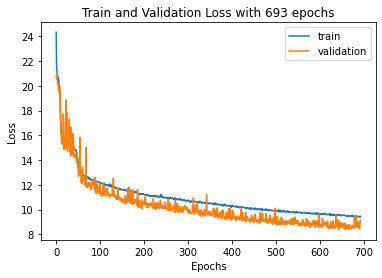

In [14]:
patience=50
# plot training and validation history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('Epochs')
plt.ylabel('Loss') 
plt.title('Train and Validation Loss with '+str(len(history.history['val_loss']))+' epochs')
plt.legend()
 
plt.savefig('train_validation_after_'+str(len(history.history['val_loss'])-patience)+"_epochs.png")

print('The optimal number of epochs is '+str(len(history.history['val_loss'])-patience))

In [15]:
predict3=np.zeros((l2r,8))

for i in range(408289,408800):
    predict3[i-408289]=predictions[i]
    
predict2=np.zeros((l2r,8))

for i in range(407778,408289):
    predict2[i-407778]=predictions[i]
    
predict1=np.zeros((l2r,8))

for i in range(407267,407778):
    predict1[i-407267]=predictions[i]

In [16]:
ltype = 'mean_squared_error'
ltype2=tf.keras.metrics.RootMeanSquaredError()
bsize = 1024


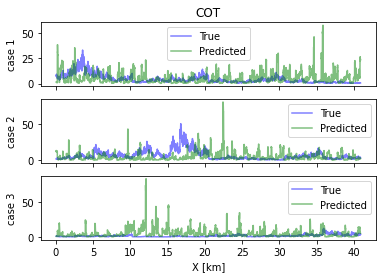

In [19]:
# plotting ------------------------------------------------------
fgnm = "predict"+"_"+str(ltype)+"_"+str(bsize)+"_"+str(len(history.history['val_loss'])-patience)+'DNN connection patience50'
fig, axs = plt.subplots(nrows=3,ncols=1,sharex=True)

# plots the last three test profiles

#plot the third last profile
ax = axs[0]
ax.set_title(r"COT")
ax.plot(x[halo:os*l2r+halo],data[num-3,halo:os*l2r+halo,3].T,alpha=0.5,color="blue")
ax.plot(x[halo:os*l2r+halo],predict1.reshape(4088),alpha=0.5,color="green")
ax.legend(["True", "Predicted"])
ax.set_ylabel(r"case 1") 

#plot the second last profile
ax = axs[1]
ax.plot(x[halo:os*l2r+halo],data[num-2,halo:os*l2r+halo,3].T,alpha=0.5,color="blue")
ax.plot(x[halo:os*l2r+halo],predict2.reshape(4088),alpha=0.5,color="green")
ax.legend(["True", "Predicted"])
ax.set_ylabel(r"case 2")  

# plot the last profile
ax = axs[2]
ax.plot(x[halo:os*l2r+halo],data[num-1,halo:os*l2r+halo,3].T,alpha=0.5,color="blue")
ax.plot(x[halo:os*l2r+halo],predict3.reshape(4088),alpha=0.5,color="green")
ax.legend(["True", "Predicted"])
ax.set_ylabel(r"case 3")  
ax.set_xlabel('X [km]')

plt.savefig(fgnm+".png",dpi=300,bbox_inches='tight')


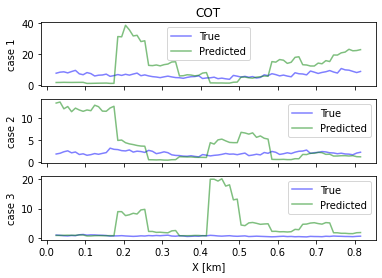

In [20]:
# plotting ------------------------------------------------------
fgnm = "predict"+"_"+str(ltype)+"_"+str(bsize)+"_"+str(len(history.history['val_loss'])-patience)+"_first_80_pixels_DNN patience50"
fig, axs = plt.subplots(nrows=3,ncols=1,sharex=True)

# plots the first 80 pixels in last three test images

#plot the third last profile
ax = axs[0]
ax.set_title(r"COT")
ax.plot(x[halo:os*l2r+halo][:80],data[num-3,halo:os*l2r+halo,3][:80].T,alpha=0.5,color="blue") 
ax.plot(x[halo:os*l2r+halo][:80],predict1.reshape(4088)[:80],alpha=0.5,color="green")
ax.legend(["True", "Predicted"])
ax.set_ylabel(r"case 1") 

#plot the second last profile
ax = axs[1]
ax.plot(x[halo:os*l2r+halo][:80],data[num-2,halo:os*l2r+halo,3][:80].T,alpha=0.5,color="blue") 
ax.plot(x[halo:os*l2r+halo][:80],predict2.reshape(4088)[:80],alpha=0.5,color="green")
ax.legend(["True", "Predicted"])
ax.set_ylabel(r"case 2")  

# plot the last profile
ax = axs[2]
ax.plot(x[halo:os*l2r+halo][:80],data[num-1,halo:os*l2r+halo,3][:80].T,alpha=0.5,color="blue")
ax.plot(x[halo:os*l2r+halo][:80],predict3.reshape(4088)[:80],alpha=0.5,color="green")
ax.legend(["True", "Predicted"])
ax.set_ylabel(r"case 3")  
ax.set_xlabel('X [km]')

plt.savefig(fgnm+".png",dpi=300,bbox_inches='tight')